In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_columns = 30
pd.options.display.max_colwidth = 150

## data import

In [3]:
frame = pd.read_csv('..//1_web_scraping//apartment_details.csv')

In [4]:
frame.head()

,city,district,voivodeship,localization_y,localization_x,market,offer_type,area,rooms,floor,floors,build_yr,price,url
0,Kraków,NaN,małopolskie,50.015650,19.988633,pierwotny,sprzedaz,85.12,4,NaN,5,NaN,952000,https://gratka.pl/nieruchomosci/nowe-mieszkanie-krakow-ul-facimiech/ob/25557745
1,Kołobrzeg,kołobrzeski,zachodniopomorskie,54.175917,15.583267,wtorny,sprzedaz,75.85,2,4,4,1970.0,850000,https://gratka.pl/nieruchomosci/mieszkanie-kolobrzeg/ob/25201643
2,Bydgoszcz,Fordon,kujawsko-pomorskie,53.141262,18.124716,pierwotny,sprzedaz,43.16,2,4,NaN,NaN,Zapytajoce,https://gratka.pl/nieruchomosci/nowe-mieszkanie-bydgoszcz-fordon-ul-akademicka/ob/26034877
3,Zakopane,tatrzański,małopolskie,49.294420,19.980946,pierwotny,sprzedaz,51.00,2,1,3,NaN,770000,https://gratka.pl/nieruchomosci/nowe-mieszkanie-zakopane-ul-salwatorianska/ob/24164937
4,Wałbrzych,NaN,dolnośląskie,50.784783,16.284914,wtorny,sprzedaz,59.90,3,4,4,NaN,229000,https://gratka.pl/nieruchomosci/mieszkanie-walbrzych/ob/26462687


In [5]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98166 entries, 0 to 98165
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   city            97511 non-null  object 
 1   district        79199 non-null  object 
 2   voivodeship     97511 non-null  object 
 3   localization_y  97139 non-null  float64
 4   localization_x  97766 non-null  float64
 5   market          92807 non-null  object 
 6   offer_type      92808 non-null  object 
 7   area            97411 non-null  float64
 8   rooms           96725 non-null  object 
 9   floor           95002 non-null  object 
 10  floors          72442 non-null  object 
 11  build_yr        55801 non-null  float64
 12  price           97511 non-null  object 
 13  url             98166 non-null  object 
dtypes: float64(4), object(10)
memory usage: 10.5+ MB


In [6]:
frame.describe().T

,count,mean,std,min,25%,50%,75%,max
localization_y,97139.0,51.576559,2.672358,-0.002747,50.317778,52.156798,52.991282,85.05113
localization_x,97766.0,17.767082,11.697809,-157.827000,18.054872,19.227171,20.926981,55.39860
area,97411.0,59.830341,27.992648,10.000000,43.060000,54.600000,68.160000,796.00000
build_yr,55801.0,1996.723302,33.299318,1200.000000,1979.000000,2012.000000,2022.000000,2025.00000


In [7]:
len(frame) == len(frame.drop_duplicates())

True

In [8]:
frame.offer_type.value_counts(normalize=True)

sprzedaz    1.0
Name: offer_type, dtype: float64

## renaming market type

In [9]:
frame.market.replace(['pierwotny','wtorny'], ['primary_market','aftermarket'], inplace=True)

## removing foreign locations

In [10]:
len(frame[frame.voivodeship=='zagranica'])/len(frame)

0.014444919829676262

In [11]:
frame.drop(frame[frame.voivodeship=='zagranica'].index, inplace=True)

## removing data with no price

In [12]:
frame.price.value_counts(normalize=True).loc['Zapytajoce']

0.18046059546481014

In [13]:
frame.drop(index=frame[frame.price=='Zapytajoce'].index, axis=0, inplace=True)

In [14]:
frame.price = frame.price.apply(float)

## checking the amount of missing data and removing rows with small amount of missing data per column

In [15]:
num_desc = frame.describe().T
num_desc['%missing'] = (1-num_desc['count']/len(frame))*100
num_desc

,count,mean,std,min,25%,50%,75%,max,%missing
localization_y,78474.0,51.872995,1.441995,-0.002747,50.397317,52.150683,52.653200,8.505113e+01,1.174959
localization_x,79101.0,19.226406,2.233771,-99.999990,18.081980,19.437186,20.939234,2.385012e+01,0.385356
area,78652.0,60.488119,28.832004,10.000000,44.000000,55.000000,69.000000,7.960000e+02,0.950798
build_yr,54843.0,1996.329668,33.440728,1200.000000,1978.000000,2011.000000,2022.000000,2.025000e+03,30.934301
price,78752.0,606490.427900,548886.303710,1.000000,363880.500000,492012.000000,670000.000000,2.135010e+07,0.824864


In [16]:
obj_desc = frame.describe(include=['object']).T
obj_desc['%missing'] = (1-obj_desc['count']/len(frame))*100
obj_desc

,count,unique,top,freq,%missing
city,78752,1612,Warszawa,14624,0.824864
district,65164,1178,Śródmieście,3824,17.9367
voivodeship,78752,16,mazowieckie,18028,0.824864
market,76305,2,aftermarket,52442,3.90646
offer_type,76306,1,sprzedaz,76306,3.9052
rooms,78266,9,3,29631,1.4369
floor,76736,35,1,17928,3.36368
floors,70185,31,4,20372,11.6136
url,79407,79407,https://gratka.pl/nieruchomosci/nowe-mieszkanie-warszawa-rembertow/ob/26253749,1,0


In [17]:
frame.dropna(subset=['price','localization_y','localization_x','area'], axis=0, inplace=True)

In [18]:
frame.dropna(subset=['market','offer_type','rooms','floor'], axis=0, inplace=True)

## dealing with missing data for 'floors', 'district', 'build_yr'

In [19]:
frame.dropna(subset=['build_yr'], axis=0, inplace=True)

In [20]:
len(frame[pd.isnull(frame.floors)])/len(frame)

0.023404654654654654

In [21]:
frame.dropna(subset=['floors'], axis=0, inplace=True)

In [22]:
# district will be left with missing data

In [23]:
frame.shape

(52033, 14)

## checking categorical data

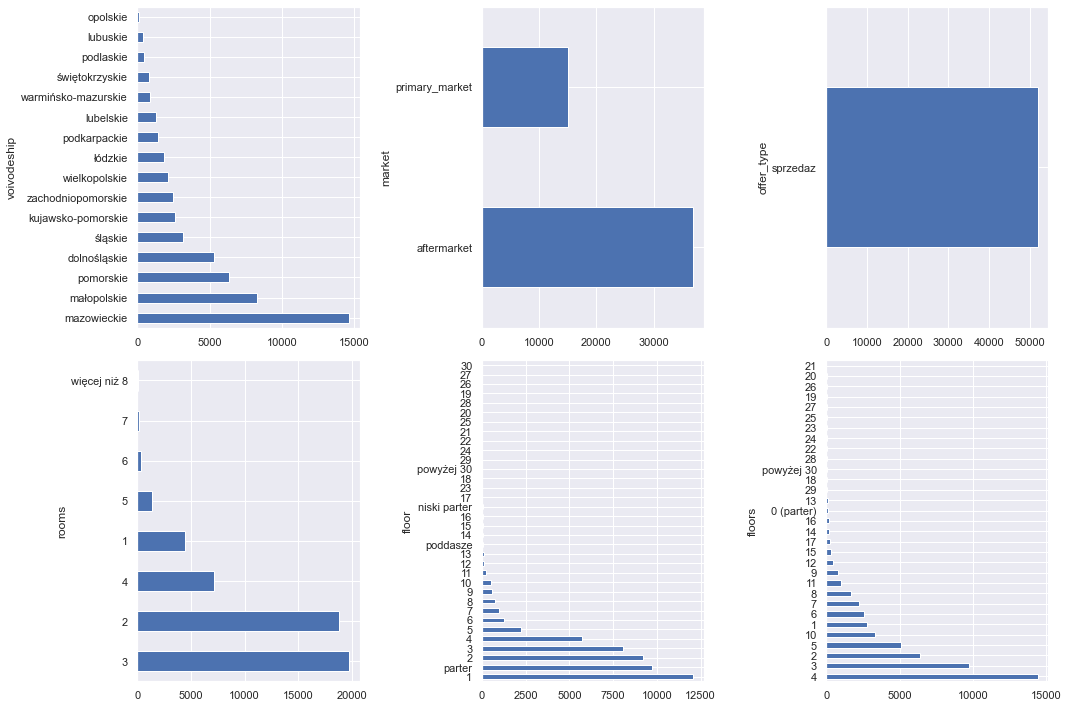

In [24]:
fig, axList = plt.subplots(nrows=2, ncols=3)
axList = axList.flatten()
fig.set_size_inches(15,10)

catagorical_columns = [x for x in frame.columns if frame[x].dtype == 'object' and x not in ['city','district','url']]

for ax, column in zip(axList, catagorical_columns):
    frame[column].value_counts().plot(kind='barh', ax=ax, ylabel=column)
    
plt.tight_layout()

In [25]:
frame.rooms.replace('więcej niż 8', '8', inplace=True)
frame.rooms = frame.rooms.astype('int')

In [26]:
frame.floor.replace(['niski parter','parter'], '0', inplace=True)
frame.floor.replace('powyżej 30', '30', inplace=True)
frame.drop(frame[frame.floor=='poddasze'].index, axis=0, inplace=True)
frame.floor = frame.floor.astype('int')

In [27]:
frame.floors.replace(['0 (parter)','powyżej 30'], ['0','30'], inplace=True)
frame.floors = frame.floors.astype('int')

In [28]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51967 entries, 1 to 98164
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   city            51967 non-null  object 
 1   district        44216 non-null  object 
 2   voivodeship     51967 non-null  object 
 3   localization_y  51967 non-null  float64
 4   localization_x  51967 non-null  float64
 5   market          51967 non-null  object 
 6   offer_type      51967 non-null  object 
 7   area            51967 non-null  float64
 8   rooms           51967 non-null  int32  
 9   floor           51967 non-null  int32  
 10  floors          51967 non-null  int32  
 11  build_yr        51967 non-null  float64
 12  price           51967 non-null  float64
 13  url             51967 non-null  object 
dtypes: float64(5), int32(3), object(6)
memory usage: 5.4+ MB


## adding custom column

In [29]:
frame['price_of_sqm'] = frame.price / frame.area

## dealing with outliers

In [30]:
# checking quantile values

outliers_dict = dict()

for column in ['area','build_yr','price','price_of_sqm']:
    upper_quartile = np.nanpercentile(frame[column], 99.0)
    lower_quartile = np.nanpercentile(frame[column], 1.0)
#     iqr = upper_quartile - lower_quartile
#     outliers_dict[column] = (lower_quartile-1.5*iqr, upper_quartile+1.5*iqr)
    outliers_dict[column] = (lower_quartile, upper_quartile)

outliers_dict

{'area': (24.0, 168.26059999999967),
 'build_yr': (1900.0, 2024.0),
 'price': (180000.0, 2893960.4999999944),
 'price_of_sqm': (3458.3162031438933, 27451.468435104638)}

In [31]:
frame[['area','build_yr','price','price_of_sqm']].describe().T

,count,mean,std,min,25%,50%,75%,max
area,51967.0,61.121745,29.474299,12.000000,44.000000,55.440000,69.700000,7.520000e+02
build_yr,51967.0,1995.903496,33.327901,1200.000000,1978.000000,2010.000000,2022.000000,2.025000e+03
price,51967.0,664453.178344,600816.186181,75000.000000,399000.000000,530000.000000,720000.000000,2.135010e+07
price_of_sqm,51967.0,10828.806146,4819.490299,592.391304,7602.739726,9977.777778,12912.686519,9.598930e+04


In [32]:
outliers_dict['build_yr'] = (1900.0, 2024.0)

In [33]:
for key in outliers_dict.keys():
    frame.drop(frame[frame[key] < outliers_dict[key][0]].index, inplace = True)
    frame.drop(frame[frame[key] > outliers_dict[key][1]].index, inplace = True)

In [34]:
frame[['area','build_yr','price','price_of_sqm']].describe().T

,count,mean,std,min,25%,50%,75%,max
area,49297.0,59.360291,22.407138,24.000000,44.490000,55.200000,68.600000,1.682300e+02
build_yr,49297.0,1997.709739,29.941068,1900.000000,1980.000000,2011.000000,2022.000000,2.024000e+03
price,49297.0,619336.134856,347293.316186,180000.000000,407232.000000,530000.000000,701300.000000,2.893425e+06
price_of_sqm,49297.0,10605.526654,4015.539006,3458.333333,7680.722892,9939.759036,12731.481481,2.743296e+04


## dealing with outliers in localization

In [35]:
frame.localization_x.min(), frame.localization_x.max()

(-99.99999, 23.612565)

In [36]:
frame.localization_y.min(), frame.localization_y.max()

(-0.00274658, 85.05113)

In [37]:
outliers_dict_2 = dict()
outliers_dict_2['localization_x'] = (14,25)
outliers_dict_2['localization_y'] = (48,55)

In [38]:
for key in outliers_dict_2.keys():
    frame.drop(frame[frame[key] < outliers_dict_2[key][0]].index, inplace = True)
    frame.drop(frame[frame[key] > outliers_dict_2[key][1]].index, inplace = True)

In [39]:
len(frame[(frame.localization_x%1==0) | (frame.localization_y%1==0)])

32

In [40]:
frame.drop(frame[(frame.localization_x%1==0) | (frame.localization_y%1==0)].index,inplace=True)

## checking histograms

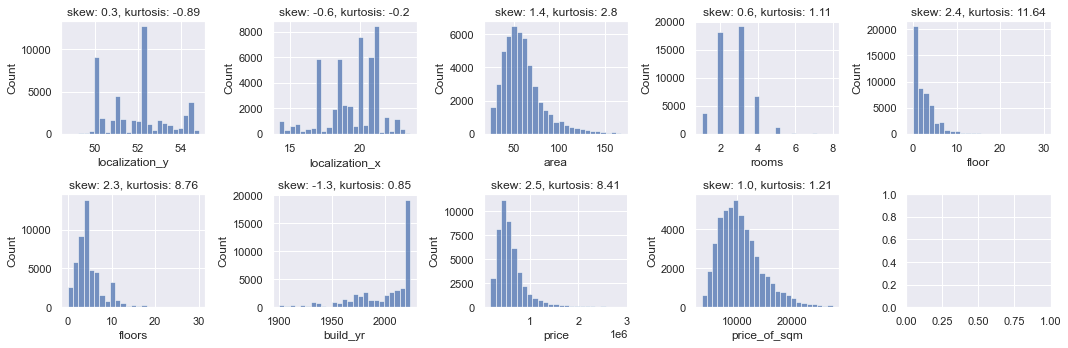

In [41]:
fig, axList = plt.subplots(nrows=2, ncols=5)
axList = axList.flatten()
fig.set_size_inches(15,5)

numeric_columns = [x for x in frame.columns if frame[x].dtype in ['float64','int32']]
kurtosis_dict = dict(frame[numeric_columns].kurtosis())

for ax, column in zip(axList, numeric_columns):
    sns.histplot(frame, x=frame[column], ax=ax, bins=25)
    ax.title.set_text(f'skew: {round(frame[column].skew(), 1)}, kurtosis: {round(kurtosis_dict[column], 2)}')
    
plt.tight_layout()

## data summary

In [42]:
frame.describe().T

,count,mean,std,min,25%,50%,75%,max
localization_y,49263.0,51.934690,1.420051,48.741100,50.837440,52.184300,52.533425,5.483224e+01
localization_x,49263.0,19.388761,1.880816,14.218489,18.368965,19.919131,20.973502,2.361257e+01
area,49263.0,59.359105,22.409410,24.000000,44.490000,55.200000,68.600000,1.682300e+02
rooms,49263.0,2.684165,0.929915,1.000000,2.000000,3.000000,3.000000,8.000000e+00
floor,49263.0,2.513266,2.564514,0.000000,1.000000,2.000000,3.000000,3.000000e+01
floors,49263.0,4.922802,3.332986,0.000000,3.000000,4.000000,6.000000,3.000000e+01
build_yr,49263.0,1997.714187,29.936368,1900.000000,1980.000000,2011.000000,2022.000000,2.024000e+03
price,49263.0,619429.061547,347359.774713,180000.000000,407502.000000,530025.000000,701300.000000,2.893425e+06
price_of_sqm,49263.0,10607.193547,4015.768293,3458.333333,7681.818182,9940.005651,12735.139035,2.743296e+04


In [43]:
frame.describe(include=['object']).T

,count,unique,top,freq
city,49263,876,Warszawa,11568
district,41912,1011,Śródmieście,2194
voivodeship,49263,16,mazowieckie,13944
market,49263,2,aftermarket,34578
offer_type,49263,1,sprzedaz,49263
url,49263,49263,https://gratka.pl/nieruchomosci/mieszkanie-warszawa-srodmiescie-ul-antonia-corazziego/ob/26430279,1


In [44]:
frame.reset_index(drop=True, inplace=True)

In [45]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49263 entries, 0 to 49262
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   city            49263 non-null  object 
 1   district        41912 non-null  object 
 2   voivodeship     49263 non-null  object 
 3   localization_y  49263 non-null  float64
 4   localization_x  49263 non-null  float64
 5   market          49263 non-null  object 
 6   offer_type      49263 non-null  object 
 7   area            49263 non-null  float64
 8   rooms           49263 non-null  int32  
 9   floor           49263 non-null  int32  
 10  floors          49263 non-null  int32  
 11  build_yr        49263 non-null  float64
 12  price           49263 non-null  float64
 13  url             49263 non-null  object 
 14  price_of_sqm    49263 non-null  float64
dtypes: float64(6), int32(3), object(6)
memory usage: 5.1+ MB


## saving the frame

In [46]:
outfile = open('apartment_data_frame','wb')
pkl.dump(frame, outfile)
outfile.close()